# Important! Read Me!

This notebook requires a paid OpenAI API account to run. It cost about 25 cents to execute the script. If you have an API key, you can set it up following [these instructions](https://platform.openai.com/docs/quickstart). You might be able to make it cheaper by doing more queries per call, but I was worried about maximum length.

In [1]:
from pyprojroot import here
import sys
sys.path.insert(0, str(here()))

import pandas as pd
import yaml
import geopandas as gpd
from laos_gggi import load_emdat_data, load_shapefile
import matplotlib.pyplot as plt
from laos_gggi.plotting import configure_plot_style
from geopy.geocoders import Nominatim
import numpy as np
import warnings

configure_plot_style()
geolocator = Nominatim(user_agent="laos_gggi")
emdat = load_emdat_data()

In [ ]:
queries = []
for idx, row in emdat['df_raw_filtered_adj'].iterrows():
    queries.append(f'ID:{idx}\nCountry:{row.Country}\nRegion:{row.Region}\nLocation:{row.Location}')

In [ ]:
n_queries = len(queries)
n_queries

In [ ]:
from openai import OpenAI
client = OpenAI()

SYSTEM_PROMPT = {"role": "system",
                 "content": '''You are a simulated geography lookup system. As input, you take descriptions of places, potentially many places, potentially in a very messy format. As output, return a YAML file with the ID as a key, then numerical subkeys, one for each likely location described by provided data, starting with zero. If a reasonable person would believe there are multiple locations, the data is split into sub-locations. For each entry, the YAML returns the most descriptive, most proximate location name as a string, along with its approximate latitude and longitude as floats'''}
EXAMPLE_EXCHANGE = [{
            "role": "user",
            "content": '''ID: 26420
Country: Chile
Region: Americas
Location: Viña del Mar City, Quilpué City (Marga Marga Province; Valparaíso Region); O'Higgins, Maule, Ñuble, Los Ríos, Arucania, Aysén regions'''
        },
        {
            "role":"assistant",
            "content":'''
            26420:
  0:
    name: "Viña del Mar City, Marga Marga Province, Valparaíso Region, Chile"
    lat: -33.0245
    long: -71.5518
  1:
    name: "Quilpué City, Marga Marga Province, Valparaíso Region, Chile"
    lat: -33.0493
    long: -71.4417
  2:
    name: "O'Higgins Region, Chile"
    lat: -34.5754
    long: -70.9727
  3:
    name: "Maule Region, Chile"
    lat: -35.4266
    long: -71.6554
  4:
    name: "Ñuble Region, Chile"
    lat: -36.7226
    long: -71.9577
  5:
    name: "Los Ríos Region, Chile"
    lat: -39.8088
    long: -72.7370
  6:
    name: "Arucania Region, Chile"
    lat: -38.7406
    long: -72.5903
  7:
    name: "Aysén Region, Chile"
    lat: -45.7373
    long: -72.0695
            '''
        }]

## Query GPT

Uncomment this cell to actually query ChatGPT

In [5]:
# gpt_outputs = []

# for i in range(n_queries, 10):
#     idx = slice(i, i + 10)
#     print(idx)
#     input_str = '\n'.join(queries[idx])
#     completion = client.chat.completions.create(
#         model="gpt-4o-mini",
#         messages=[SYSTEM_PROMPT,
#                   *EXAMPLE_EXCHANGE,
#                   {
#                       "role": "user",
#                       "content": input_str
#                   }
#         ]
#     )
#     gpt_outputs.append(completion.choices[0].message)

### Post-process GPT outputs

Simple first pass, remove the yaml tags and remove spaces from negative numbers (GPT returns `- 9` instead of `-9`)

In [6]:
# import re

# def process_output(x):
#     msg = str(x.content)
#     msg = re.sub('\- (\d*)', '-\g<0>', msg)
#     return msg.replace('```yaml', '').replace('```', '').strip()

# res = list(map(process_output, gpt_outputs))

## Save raw data 

Any errors were fixed by hand in the file, so that part isn't reproducable. ChatGPT spewed out nonsense some percentage of the time. This might be better if you use `gpt-4o` instead of `gpt-4o-mini`.

In [7]:
# with open(here('data/locations.yaml'), 'a') as file:
#     for chunk in res:
#         file.write(chunk)
#         file.write('\n')

# Load data

After all noise is removed from the `locations.yaml` written above, it can be loaded. If this is already done, you can just load the CSV that was created.

In [2]:
# with open(here('data/locations.yaml'), 'r') as file:
#     locs = yaml.safe_load(file)
    
# loc_dfs = []
# for idx, data in locs.items():
#     if list(data.keys())[0] != 0:
#         data = {0: data}
#     temp = pd.DataFrame(data)
#     temp.loc['idx'] = idx
#     temp = (temp.T
#                 .reset_index()
#                 .rename(columns={'index':'location_id', 
#                                  'idx':'emdat_index'})
#                 .set_index(['emdat_index', 'location_id'])
#                 .assign(lat = lambda x: x.lat.astype(float),
#                         long = lambda x: x.long.astype(float))
#            )
#     loc_dfs.append(temp)
# loc_df = pd.concat(loc_dfs)

# loc_df.to_csv(here('location_data_for_emdat.csv'))

loc_df = pd.read_csv(here('location_data_for_emdat.csv'), index_col=['emdat_index', 'location_id'])

In [3]:
#Load world bank shapefiles
world_shapefiles = load_shapefile('world', repair_ISO_codes=True, force_reload=True)

world_shapefiles = world_shapefiles.rename(columns={"ISO_A3": "WB_ISO"})

Extracting C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\wb_countries_admin0_10m


## Spot check some results

In [4]:
n_to_check = 10
to_check = loc_df.sample(n_to_check).T.to_dict()

In [5]:
check_dict = {}
for key, d in to_check.items():
    check_dict[key] = d.copy()
    for sub_dict in d.values():
        lat = d['lat']
        lon = d['long']
        
        # Do a geo-lookup on the lat-long that GPT gave us, check if the address matches
        location = geolocator.reverse(f"{lat},{lon}")
        check_dict[key]['geopy'] = location

In [6]:
pd.DataFrame(check_dict).T.assign(address = lambda x: x.geopy.map(lambda y: y.address if y is not None else None))

,,name,lat,long,geopy,address
11185,7,"Roi Et Province, Thailand",16.0864,103.6568,"(บ้านโพน, จังหาร, จังหวัดร้อยเอ็ด, 45170, ประเ...","บ้านโพน, จังหาร, จังหวัดร้อยเอ็ด, 45170, ประเท..."
12025,7,"Gdańsk District, Pomorskie Province, Poland",54.3492,18.6466,"(PKO BP, 3, Okopowa, Stare Przedmieście, Śródm...","PKO BP, 3, Okopowa, Stare Przedmieście, Śródmi..."
14808,14,"Santa Barbara Province, Honduras",14.1464,-88.9315,"(La Laguna, Chalatenango, El Salvador, (14.151...","La Laguna, Chalatenango, El Salvador"
11597,3,"Guéra prefecture, Chad",11.0,19.75,"(Salamat سلامات, Tchad تشاد, (10.7575596, 20.6...","Salamat سلامات, Tchad تشاد"
17628,8,"Intibuca Province, Honduras",14.154,-88.1738,"(San Marcos de Sierra, Intibucá, Honduras, (14...","San Marcos de Sierra, Intibucá, Honduras"
17933,12,"Vatomandry District, Madagascar",-19.2887,48.1738,"(Alaotra-Mangoro, Province de Tamatave, Madaga...","Alaotra-Mangoro, Province de Tamatave, Madagas..."
9559,1,"Chateauguay, Quebec, Canada",45.3666,-74.3267,"(3e Rang, Sainte-Justine-de-Newton, Vaudreuil-...","3e Rang, Sainte-Justine-de-Newton, Vaudreuil-S..."
15591,5,"Harbin, Heilongjiang Province, China",45.8038,126.5349,"(新湾路, 松安街道, 松北区, 哈尔滨市, 黑龙江省, 150000, 中国, (45.8...","新湾路, 松安街道, 松北区, 哈尔滨市, 黑龙江省, 150000, 中国"
22775,1,"Palpa, Nepal",27.8606,83.5437,"(NH48, Tansen--04, Tansen, पाल्पा, लुम्बिनी प्...","NH48, Tansen--04, Tansen, पाल्पा, लुम्बिनी प्र..."
7202,4,"Veracruz, Mexico",19.1738,-96.1342,"(Calzada Simón Bolívar, Ignacio Zaragoza, Vera...","Calzada Simón Bolívar, Ignacio Zaragoza, Verac..."


### Merge with emdat

In [7]:
cols = ['Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'disaster_class', 'ISO', 'Start_Year', 'Latitude', 'Longitude']
joined_df = pd.merge(loc_df.reset_index(), 
                     emdat['df_raw_filtered_adj'].reset_index(), 
                     left_on='emdat_index',
                     right_on='index',
                     how='outer')

joined_df = (joined_df.assign(emdat_index = lambda x: x.emdat_index.fillna(x['index']),
              location_id = lambda x: x.location_id.fillna(0),
             lat = lambda x: x.lat.fillna(x.Latitude),
             long = lambda x: x.long.fillna(x.Longitude))
     .drop(columns=['index', 'Latitude', 'Longitude'])
     .set_index(['emdat_index', 'location_id']))

## Visualize results

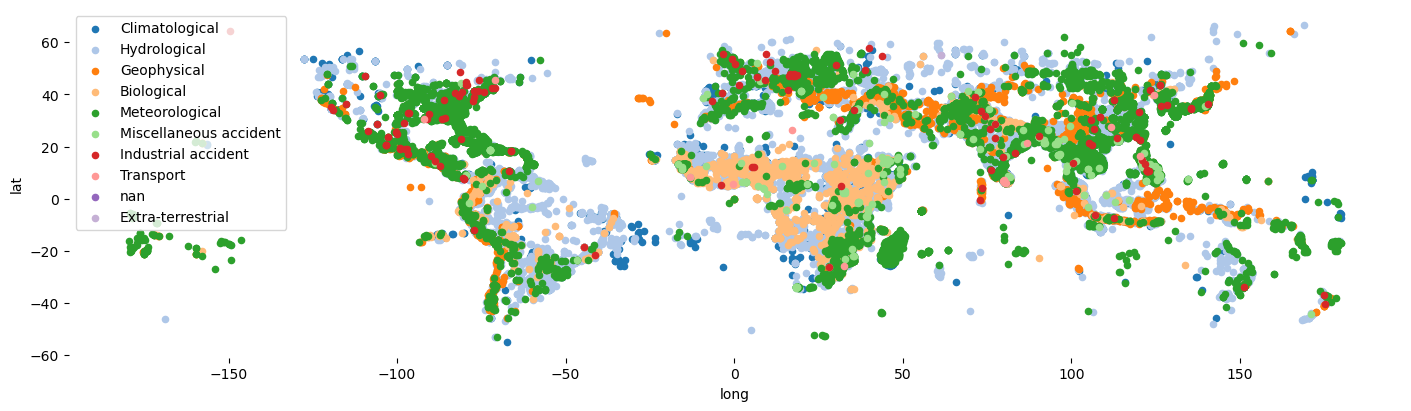

In [8]:
fig, ax = plt.subplots()
for i, group in enumerate(joined_df['Disaster Subgroup'].unique()):
    joined_df.query('`Disaster Subgroup` == @group').plot.scatter(x='long', y='lat', ax=ax, label=group,
                                                          color=plt.color_sequences['tab20'][i])

# Clean the ISO codes

In [9]:
world_shapefiles = world_shapefiles.set_index('WB_ISO')


emdat_iso =joined_df["ISO"].unique()
world_iso = world_shapefiles.index.unique()

joined_df = joined_df.reset_index().set_index("ISO")

In [10]:
# Codes in EMDAT but not in world
# These are all historical:
", ".join(list(set(emdat_iso.astype(str)) - set(world_iso)))

'TWN, SPI, TKL, GUF, SCG, REU, DFR, SUN, MTQ, YUG, ANT, nan, GLP, AZO, YMD, YMN, DDR'

In [11]:
# Codes in shapefile but not in EMDAT
", ".join(list(set(world_iso) - set(emdat_iso)))

'TKM, GIB, MCO, KWT, LIE, FRO, BHR, SGS, SHN, LVA, CYM, TCA, NFK, FLK, ARE, NRU, PCN, JEY, EST, VGB, ATF, UNK, HMD, BRN, ABW, MNP, SMR, GRL, IOT, AND, SPM, VAT, CUW, BLM, BMU, GGY, IMN, NIU, MLT, FIN, MAF'

### Drop codes not in both

In [12]:
common_codes = set(world_iso).intersection(set(emdat_iso))
joined_df = joined_df.loc[lambda x: x.index.get_level_values(0).isin(common_codes)].copy()
world_shapefiles = world_shapefiles.loc[world_shapefiles.index.isin(common_codes)].copy()

In [14]:
#reste indexes
joined_df = joined_df.reset_index().set_index(["emdat_index", "location_id"])
world_shapefiles.reset_index(inplace = True)

# Country verification

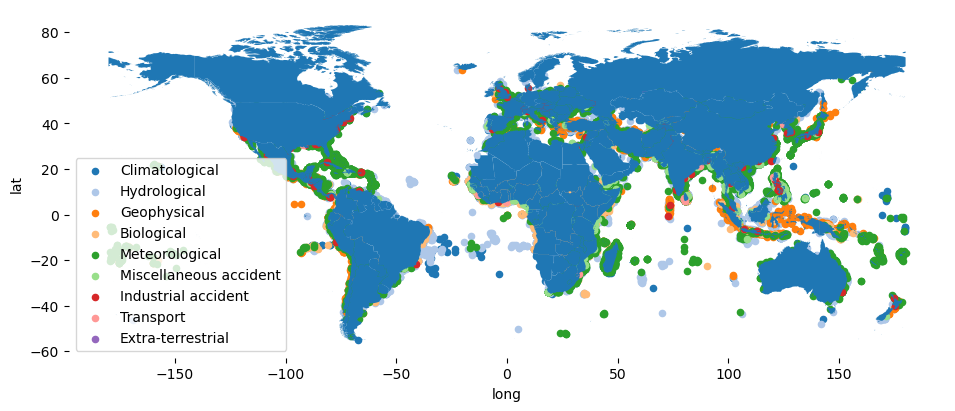

In [18]:
fig, ax = plt.subplots()
for i, group in enumerate(joined_df['Disaster Subgroup'].unique()):
    joined_df.query('`Disaster Subgroup` == @group').plot.scatter(x='long', y='lat', ax=ax, label=group,
                                                          color=plt.color_sequences['tab20'][i])

world_shapefiles.plot(ax=ax);

In [19]:
#Join the disaster coordinates with their respective country shapefiles
joined_df_geo = gpd.GeoDataFrame(
                joined_df, geometry=gpd.points_from_xy(joined_df["long"], joined_df["lat"]), crs="EPSG:4326"
            )

country_verification = joined_df_geo.sjoin(
                world_shapefiles, how="left", predicate="intersects")

In [20]:
print("There are " + 
    str(country_verification.query('WB_ISO.isna()').shape[0]) + " disasters outside country shapefiles" ) 

There are 3288 disasters outside country shapefiles


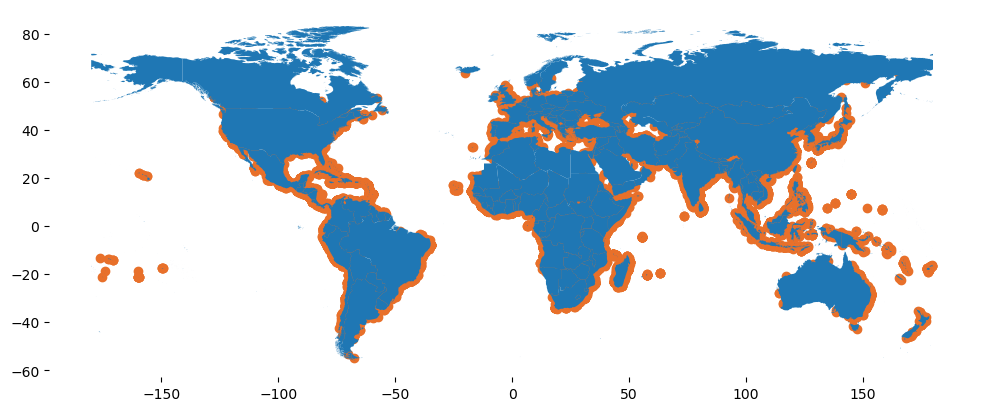

In [21]:
#Plot the points without
fig, ax = plt.subplots()
country_verification.query('WB_ISO.notna()').plot(ax=ax, c = "#e8702a")
world_shapefiles.plot(ax=ax, );

**Now we will do the same exercise by adding a 10 km buffer**

In [24]:
warnings.simplefilter("ignore") 
#Adding the buffer
buffer_size = 1
world_shapefiles_buffered = world_shapefiles.assign(geometry = lambda x: x.buffer(buffer_size) )

In [25]:
#Finding the disasters without country
country_verification_buffer = joined_df_geo.sjoin(
                world_shapefiles_buffered, how="left", predicate="intersects")

print("Once the buffer is applied, there are " + 
    str(country_verification_buffer.query('WB_ISO.isna()').shape[0]) + " disasters outside country shapefiles" ) 

Once the buffer is applied, there are 523 disasters outside country shapefiles


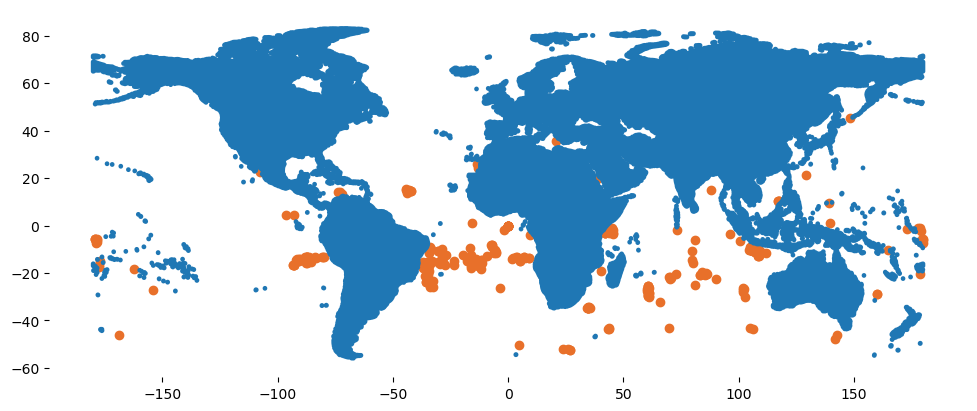

In [26]:
#Plot the points without
fig, ax = plt.subplots()
#country_verification.query('WB_ISO.notna()').plot(ax=ax, c = "#e8702a")
country_verification_buffer.query('WB_ISO.isna()').plot(ax = ax,  c = "#e8702a")
world_shapefiles_buffered.plot(ax=ax);

Now we create a new data frame dropping all the disasters that do not match a country

In [27]:
to_drop = country_verification_buffer.query('WB_ISO.isna()').index

disasters_with_countries = joined_df_geo.drop(to_drop)

#Saving the file
disasters_with_countries.to_file('data/disasters_with_countries.shp', driver='ESRI Shapefile')

Now we verify that all the countries are assigned to the right country. First, we start with the inland disasters

In [29]:
inland_disasters = country_verification.query('WB_ISO.notna()')
inland_disasters[inland_disasters["ISO"] != inland_disasters["WB_ISO"]][["ISO", "WB_ISO"]]

ISO WB_ISO
emdat_index location_id            
2262.0      4.0          ETH    IND
2377.0      1.0          ROU    MDA
2459.0      1.0          ETH    SOM
2640.0      0.0          BGD    IND
2780.0      0.0          RWA    COD
...                      ...    ...
26555.0     4.0          HND    YEM
            5.0          HND    YEM
            6.0          HND    YEM
            7.0          HND    YEM
            8.0          HND    YEM

[1664 rows x 2 columns]